<a href="https://colab.research.google.com/github/nee-no/mmWave/blob/master/stacked_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from matplotlib import pyplot 
%matplotlib inline

import math
import tensorflow as tf
import random
import copy
import os

def get_valid_data(mode): 
    in_folder = os.path.join("/content/drive/My Drive/Colab Notebooks/data")
    
    if (mode=="train"):
        x = np.load(os.path.join(in_folder, "X_train.npy"))
        y = np.load(os.path.join(in_folder, "Y_train.npy"))
        
    elif (mode=="test"):
        x = np.load(os.path.join(in_folder, "X_test.npy"))
        y = np.load(os.path.join(in_folder, "Y_test.npy"))
        
    else:
        x = np.load(os.path.join(in_folder, "X_valid.npy"))
        y = np.load(os.path.join(in_folder, "Y_valid.npy"))
    
    return x, y

# define train, test, validation ratio and split data
X, y = get_valid_data(mode="train")

X_train = X[:, 30:, :, :, :]
y_train = y[:, 30:, :]

X_valid, y_valid = get_valid_data(mode="valid")
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

X1_train = X_train.reshape(-1, 46, 500, 1)
X1_valid = X_valid.reshape(-1, 46, 500, 1)
Y1_train = y_train.reshape(-1, 61)
Y1_valid = y_valid.reshape(-1, 61)

nrows = X1_train.shape[1]
ncolumns = X1_train.shape[2]

input_shape = (nrows, ncolumns, 1)

print(X1_train.shape[0], 'train samples')
print(X1_valid.shape[0], 'valid samples')
print("Finished reading datasets")

numClasses = y_train.shape[1]
!pip install livelossplot

(863, 10, 46, 500, 1) (863, 10, 61) (863, 5, 46, 500, 1) (863, 5, 61)
8630 train samples
4315 valid samples
Finished reading datasets


In [0]:
'''
# change model layer name...
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model3 = load_model('/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_3_3_short.h5')
i=2
for j,layer in enumerate(model3.layers):
      # rename to avoid 'unique layer name' issue
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
      model3.save('/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_3_short.h5')
'''

"\n# change model layer name...\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nfrom tensorflow.keras.models import load_model\n\nmodel3 = load_model('/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_3_3_short.h5')\ni=2\nfor j,layer in enumerate(model3.layers):\n      # rename to avoid 'unique layer name' issue\n      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name\n      model3.save('/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_3_short.h5')\n"

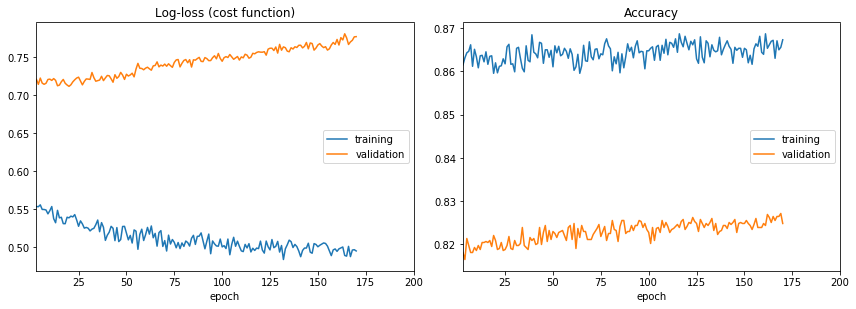

Log-loss (cost function):
training   (min:    0.484, max:    0.556, cur:    0.495)
validation (min:    0.712, max:    0.781, cur:    0.778)

Accuracy:
training   (min:    0.860, max:    0.869, cur:    0.867)
validation (min:    0.816, max:    0.827, cur:    0.825)
8630/8630 [==============================] - 137s 16ms/sample - loss: 0.4949 - acc: 0.8673 - val_loss: 0.7775 - val_acc: 0.8248


In [0]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from numpy import argmax
from livelossplot import PlotLossesKeras
import numpy as np
import tensorflow as tf
import os
 
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = '/content/drive/My Drive/Colab Notebooks/trial3_data/cnn_data_trial3data/model_' + str(i + 1) + '_short.h5'
       
        model = load_model(filename)        
        all_models.append(model)
        print('loaded %s' % filename)
        
    return all_models


# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for j,layer in enumerate(model.layers):
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
            print(layer.name)
            
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:       
            # make not trainable
            layer.trainable = False
            
            
    #members[0] = reshape_output_layer(1)
            
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    
    merge = concatenate(ensemble_outputs, axis=-1)
    hidden = Dense(128, activation='relu')(merge)
    second = Dropout(0.8)(hidden)
    output = Dense(61, activation='softmax')(second)

    model = Model(inputs=ensemble_visible, outputs=output)

    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Colab Notebooks/stack/stack_model_graph5.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy, validX, validy):
    
    X = [inputX for _ in range(len(model.input))]
    X_v = [validX for _ in range(len(model.input))]
    
    checkpoint_path = "/content/drive/My Drive/Colab Notebooks/stack/cpCombined5-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',mode='min', verbose=1, save_best_only=True)
    
    csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/stack/training5.log', append=True, separator=',')
    model.load_weights('/content/drive/My Drive/Colab Notebooks/stack/cpCombined5-0030.ckpt')
    # fit model
    history = model.fit(X, inputy, epochs=200, initial_epoch = 30, verbose=1, validation_data=(X_v, Y1_valid), callbacks=[cp_callback, csv_logger, PlotLossesKeras()])
    return history

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    #inputX = inputX.reshape((inputX.shape[0], inputX.shape[1], inputX.shape[2], 1))
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
     
    # make prediction
    return model.predict(X, verbose=0)

# load all models
n_members = 3
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

# define ensemble model
stacked_model = define_stacked_model(members)

# fit stacked model on train dataset
history = fit_stacked_model(stacked_model, X1_train, Y1_train, X1_valid, Y1_train)


In [0]:
import requests

def telegram(message):

    bot_token = '923260274:AAHyCqG6jpPI_xo0x2wJvhGVA_oeUnMf41Y'
    bot_chatID = '763781536'
    send = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + message
    try:
        response = requests.get(send)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)  
    return response.json()


telegram('stack cnn done')

In [0]:
# make predictions and evaluate
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from numpy import argmax
import numpy as np
import tensorflow as tf
import os

#stacked_model.save("/content/drive/My Drive/Colab Notebooks/stack/cpCombined-final.ckpt")
model = load_model("/content/drive/My Drive/Colab Notebooks/stack/cpCombined5-0050.ckpt")

X_test, y_test = get_valid_data(mode="test")

X1_test = X_test.reshape(-1, 46, 500, 1)
Y1_test = y_test.reshape(-1, 61)

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    #inputX = inputX.reshape((inputX.shape[0], inputX.shape[1], inputX.shape[2], 1))
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
     
    # make prediction
    return model.predict(X, verbose=0)

yhat = predict_stacked_model(model, X1_test)
#yhat = predict_stacked_model(stacked_model, X1_test)
yhat = argmax(yhat, axis=1)

temp = np.where(Y1_test==1)
print(temp)
temp = temp[1]
Y1_test_temp = temp

acc = accuracy_score(Y1_test_temp, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(array([   0,    1,    2, ..., 4312, 4313, 4314]), array([22, 22, 22, ..., 14, 14, 14]))
Stacked Test Accuracy: 0.808


In [0]:
# testing the usual way
inputX = X1_test
#inputX = X1_test.reshape((X1_test.shape[0], X1_test.shape[1], X1_test.shape[2], 1))
X = [inputX for _ in range(len(model.input))]     
test_loss, test_acc = model.evaluate(X, Y1_test, verbose = 0)

inputX = X1_valid
#inputX = X1_valid.reshape((X1_valid.shape[0], X1_valid.shape[1], X1_valid.shape[2], 1))
X = [inputX for _ in range(len(model.input))] 
valid_loss, valid_acc = model.evaluate(X, Y1_valid, verbose = 0)

inputX = X1_train
#inputX = X1_train.reshape((X1_train.shape[0], X1_train.shape[1], X1_train.shape[2], 1))
X = [inputX for _ in range(len(model.input))] 
train_loss, train_acc = model.evaluate(X, Y1_train, verbose = 0)

In [0]:

message = "stack combined \nacc" + str(acc) + "\ntest_loss :" + str(test_loss) + "\n" + "test_acc :" + str(test_acc)  + "\n" + "valid_loss :" + str(valid_loss) + "\n" + "valid_acc :" + str(valid_acc) + "\n" + "train_loss :" + str(train_loss) + "\n" + "train_acc :" + str(train_acc) 
import requests

def telegram(message):

    bot_token = '923260274:AAHyCqG6jpPI_xo0x2wJvhGVA_oeUnMf41Y'
    bot_chatID = '763781536'
    send = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + message
    try:
        response = requests.get(send)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)  
    return response.json()

telegram(message)
print(message)

stack combined 
acc0.8078794901506373
test_loss :0.8409560288642538
test_acc :0.8078795
valid_loss :0.7119445093364594
valid_acc :0.82085747
train_loss :0.3829513181057065
train_acc :0.88319814
